In [ ]:
# !pip install numpy --upgrade
# !pip install scipy --upgrade
# !pip install --user --force-reinstall numpy==1.20.0

In [1]:
import tqdm
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Function to generate dummy data
def generate_dummy_data(num_batches, events_per_batch, pulses_per_event, sensors):
    batches_meta = []
    batches_data = []
    
    for batch_id in range(num_batches):
        for event_id in range(events_per_batch):
            first_pulse_index = event_id * pulses_per_event
            last_pulse_index = (event_id + 1) * pulses_per_event - 1
            azimuth = np.random.uniform(0, 2 * np.pi)
            zenith = np.random.uniform(0, np.pi)
            
            batches_meta.append([batch_id, event_id, first_pulse_index, last_pulse_index, azimuth, zenith])
            
            for pulse_id in range(pulses_per_event):
                time = np.random.randint(0, 10000)
                sensor_id = np.random.randint(0, sensors)
                charge = np.random.normal(1, 0.1)
                auxiliary = np.random.choice([True, False])
                
                batches_data.append([event_id, time, sensor_id, charge, auxiliary])
    
    meta_df = pd.DataFrame(batches_meta, columns=['batch_id', 'event_id', 'first_pulse_index', 'last_pulse_index', 'azimuth', 'zenith'])
    data_df = pd.DataFrame(batches_data, columns=['event_id', 'time', 'sensor_id', 'charge', 'auxiliary'])
    
    return meta_df, data_df

# Parameters for dummy data generation
num_batches = 10
events_per_batch = 200
pulses_per_event = 50
sensors = 5160

train_meta, train_data = generate_dummy_data(num_batches, events_per_batch, pulses_per_event, sensors)
train_meta.to_parquet('train_meta.parquet')
train_data.to_parquet('train_data.parquet')


# Load the data
train_meta = pd.read_parquet('train_meta.parquet')
train_data = pd.read_parquet('train_data.parquet')

print(train_meta)
print(train_data)


# Normalize the sensor IDs and times
train_data['sensor_id'] = train_data['sensor_id'] / train_data['sensor_id'].max()
train_data['time'] = train_data['time'] / train_data['time'].max()

# Combine the data into one dataset for each event
def combine_event_data(event_id, train_data, max_pulses):
    event_data = train_data[train_data['event_id'] == event_id]
    if len(event_data) < max_pulses:
        padding = pd.DataFrame(np.zeros((max_pulses - len(event_data), len(event_data.columns))), columns=event_data.columns)
        event_data = pd.concat([event_data, padding])
    return np.array(event_data[['time', 'sensor_id', 'charge', 'auxiliary']].values, dtype=np.float32)

print(train_meta)

max_pulses = pulses_per_event
train_meta['event_data'] = train_meta['event_id'].apply(lambda x: combine_event_data(x, train_data, max_pulses))

print(train_meta['event_data'][0])

class NeutrinoModel(nn.Module):
    def __init__(self):
        super(NeutrinoModel, self).__init__()
        self.lstm = nn.LSTM(input_size=4, hidden_size=64, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 2)  # Predicting azimuth and zenith

    def forward(self, x):
        h_lstm, _ = self.lstm(x)
        h_lstm = h_lstm[:, -1, :]  # Take the last output of the LSTM
        x = torch.relu(self.fc1(h_lstm))
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = NeutrinoModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Prepare the data for training
X = np.stack(train_meta['event_data'].values)
y = train_meta[['azimuth', 'zenith']].values

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

# Training the model
num_epochs = 50
batch_size = 32

loss_vals=[]
val_loss_vals=[]

for epoch in tqdm.tqdm(range(num_epochs)):
    model.train()
    permutation = torch.randperm(X_train.size()[0])

    for i in range(0, X_train.size()[0], batch_size):
        indices = permutation[i:i + batch_size]
        batch_x, batch_y = X_train[indices], y_train[indices]

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss_vals.append(loss)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        val_loss_vals.append(val_loss)
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}')

# Save the model
torch.save(model.state_dict(), 'neutrino_model.pth')

test_meta, test_data = generate_dummy_data(num_batches, events_per_batch, pulses_per_event, sensors)
test_meta.to_parquet('test_meta.parquet')
test_data.to_parquet('test_data.parquet')


# Load the test data
test_meta = pd.read_parquet('test_meta.parquet')
test_data = pd.read_parquet('test_data.parquet')

# Preprocess the test data similarly
test_data['sensor_id'] = test_data['sensor_id'] / test_data['sensor_id'].max()
test_data['time'] = test_data['time'] / test_data['time'].max()
test_meta['event_data'] = test_meta['event_id'].apply(lambda x: combine_event_data(x, test_data, max_pulses))

# Prepare the test data
X_test = np.stack(test_meta['event_data'].values)
X_test = torch.tensor(X_test, dtype=torch.float32)

# Load the model
model.load_state_dict(torch.load('neutrino_model.pth'))
model.eval()

# Make predictions
with torch.no_grad():
    predictions = model(X_test)

# Save predictions to a CSV file
submission = pd.DataFrame({'event_id': test_meta['event_id'], 'azimuth': predictions[:, 0].numpy(), 'zenith': predictions[:, 1].numpy()})
submission.to_csv('submission.csv', index=False)


# epoch loss and epoch validation loss


      batch_id  event_id  first_pulse_index  last_pulse_index   azimuth  \
0            0         0                  0                49  3.278431   
1            0         1                 50                99  3.698946   
2            0         2                100               149  0.830622   
3            0         3                150               199  5.133916   
4            0         4                200               249  6.244107   
...        ...       ...                ...               ...       ...   
1995         9       195               9750              9799  0.772238   
1996         9       196               9800              9849  5.217436   
1997         9       197               9850              9899  1.754248   
1998         9       198               9900              9949  5.237115   
1999         9       199               9950              9999  0.250161   

        zenith  
0     2.572426  
1     2.942230  
2     0.131855  
3     0.466935  
4     0.400541

  2%|▏         | 1/50 [00:48<39:36, 48.50s/it]

Epoch 1/50, Loss: 2.115750789642334, Validation Loss: 2.1276485919952393


  4%|▍         | 2/50 [01:38<39:41, 49.62s/it]

Epoch 2/50, Loss: 1.6471251249313354, Validation Loss: 2.1228160858154297


  6%|▌         | 3/50 [02:29<39:17, 50.16s/it]

Epoch 3/50, Loss: 2.2347397804260254, Validation Loss: 2.12262225151062


  8%|▊         | 4/50 [03:18<38:08, 49.74s/it]

Epoch 4/50, Loss: 2.3635833263397217, Validation Loss: 2.1534533500671387


 10%|█         | 5/50 [04:06<36:40, 48.89s/it]

Epoch 5/50, Loss: 2.0423367023468018, Validation Loss: 2.134723424911499


 12%|█▏        | 6/50 [04:51<34:53, 47.57s/it]

Epoch 6/50, Loss: 1.6694931983947754, Validation Loss: 2.1391541957855225


 14%|█▍        | 7/50 [05:37<33:48, 47.18s/it]

Epoch 7/50, Loss: 2.2232706546783447, Validation Loss: 2.1440024375915527


 16%|█▌        | 8/50 [06:23<32:39, 46.66s/it]

Epoch 8/50, Loss: 1.913744330406189, Validation Loss: 2.1435952186584473


 18%|█▊        | 9/50 [07:09<31:48, 46.54s/it]

Epoch 9/50, Loss: 1.3569729328155518, Validation Loss: 2.125026226043701


 20%|██        | 10/50 [07:55<30:59, 46.50s/it]

Epoch 10/50, Loss: 2.011674165725708, Validation Loss: 2.1335108280181885


 22%|██▏       | 11/50 [08:43<30:21, 46.72s/it]

Epoch 11/50, Loss: 2.050429582595825, Validation Loss: 2.125680923461914


 24%|██▍       | 12/50 [09:28<29:16, 46.22s/it]

Epoch 12/50, Loss: 1.7823901176452637, Validation Loss: 2.127450942993164


 26%|██▌       | 13/50 [10:13<28:18, 45.91s/it]

Epoch 13/50, Loss: 2.4908807277679443, Validation Loss: 2.1471688747406006


 28%|██▊       | 14/50 [11:00<27:42, 46.18s/it]

Epoch 14/50, Loss: 2.2626919746398926, Validation Loss: 2.1196975708007812


 30%|███       | 15/50 [11:46<26:57, 46.22s/it]

Epoch 15/50, Loss: 1.9886159896850586, Validation Loss: 2.142463445663452


 32%|███▏      | 16/50 [12:33<26:24, 46.60s/it]

Epoch 16/50, Loss: 2.4896342754364014, Validation Loss: 2.126448154449463


 34%|███▍      | 17/50 [13:20<25:33, 46.47s/it]

Epoch 17/50, Loss: 2.0532402992248535, Validation Loss: 2.1233556270599365


 36%|███▌      | 18/50 [14:07<24:55, 46.73s/it]

Epoch 18/50, Loss: 1.8673663139343262, Validation Loss: 2.1395349502563477


 38%|███▊      | 19/50 [14:53<24:04, 46.60s/it]

Epoch 19/50, Loss: 2.064640998840332, Validation Loss: 2.141195297241211


 40%|████      | 20/50 [15:40<23:23, 46.78s/it]

Epoch 20/50, Loss: 1.9123424291610718, Validation Loss: 2.132272720336914


 42%|████▏     | 21/50 [16:27<22:39, 46.88s/it]

Epoch 21/50, Loss: 2.014105796813965, Validation Loss: 2.120440721511841


 44%|████▍     | 22/50 [17:13<21:42, 46.53s/it]

Epoch 22/50, Loss: 2.306878089904785, Validation Loss: 2.1205074787139893


 46%|████▌     | 23/50 [17:59<20:51, 46.37s/it]

Epoch 23/50, Loss: 1.9585237503051758, Validation Loss: 2.170112371444702


 48%|████▊     | 24/50 [18:46<20:08, 46.47s/it]

Epoch 24/50, Loss: 2.103943347930908, Validation Loss: 2.1252846717834473


 50%|█████     | 25/50 [19:33<19:27, 46.68s/it]

Epoch 25/50, Loss: 2.378312587738037, Validation Loss: 2.1293885707855225


 52%|█████▏    | 26/50 [20:20<18:41, 46.72s/it]

Epoch 26/50, Loss: 2.269521474838257, Validation Loss: 2.1268105506896973


 54%|█████▍    | 27/50 [21:07<17:58, 46.90s/it]

Epoch 27/50, Loss: 2.264432191848755, Validation Loss: 2.1379752159118652


 56%|█████▌    | 28/50 [21:52<17:00, 46.38s/it]

Epoch 28/50, Loss: 2.035173177719116, Validation Loss: 2.1365151405334473


 58%|█████▊    | 29/50 [22:40<16:18, 46.60s/it]

Epoch 29/50, Loss: 2.1799302101135254, Validation Loss: 2.124342203140259


 60%|██████    | 30/50 [23:27<15:36, 46.84s/it]

Epoch 30/50, Loss: 2.2156283855438232, Validation Loss: 2.124612808227539


 62%|██████▏   | 31/50 [24:16<15:05, 47.64s/it]

Epoch 31/50, Loss: 1.8301880359649658, Validation Loss: 2.1415815353393555


 64%|██████▍   | 32/50 [25:05<14:25, 48.07s/it]

Epoch 32/50, Loss: 1.6995900869369507, Validation Loss: 2.146311044692993


 66%|██████▌   | 33/50 [25:54<13:38, 48.14s/it]

Epoch 33/50, Loss: 2.649401903152466, Validation Loss: 2.133439540863037


 68%|██████▊   | 34/50 [26:44<12:57, 48.61s/it]

Epoch 34/50, Loss: 2.274235963821411, Validation Loss: 2.1228249073028564


 70%|███████   | 35/50 [27:31<12:05, 48.40s/it]

Epoch 35/50, Loss: 2.502042770385742, Validation Loss: 2.1294355392456055


 72%|███████▏  | 36/50 [28:20<11:18, 48.49s/it]

Epoch 36/50, Loss: 2.360889196395874, Validation Loss: 2.1203341484069824


 74%|███████▍  | 37/50 [29:08<10:26, 48.16s/it]

Epoch 37/50, Loss: 2.9809343814849854, Validation Loss: 2.1445019245147705


 76%|███████▌  | 38/50 [29:59<09:50, 49.22s/it]

Epoch 38/50, Loss: 2.5875937938690186, Validation Loss: 2.1654868125915527


 78%|███████▊  | 39/50 [30:47<08:57, 48.85s/it]

Epoch 39/50, Loss: 2.0228524208068848, Validation Loss: 2.131340980529785


 80%|████████  | 40/50 [31:36<08:08, 48.84s/it]

Epoch 40/50, Loss: 1.9231061935424805, Validation Loss: 2.121854782104492


 82%|████████▏ | 41/50 [32:27<07:24, 49.40s/it]

Epoch 41/50, Loss: 2.1420159339904785, Validation Loss: 2.1222896575927734


 84%|████████▍ | 42/50 [33:15<06:32, 49.00s/it]

Epoch 42/50, Loss: 2.6343932151794434, Validation Loss: 2.132641553878784


 86%|████████▌ | 43/50 [34:03<05:41, 48.83s/it]

Epoch 43/50, Loss: 1.9876370429992676, Validation Loss: 2.1446385383605957


 88%|████████▊ | 44/50 [34:55<04:57, 49.60s/it]

Epoch 44/50, Loss: 2.5895135402679443, Validation Loss: 2.1327638626098633


 90%|█████████ | 45/50 [35:50<04:16, 51.28s/it]

Epoch 45/50, Loss: 2.65946626663208, Validation Loss: 2.1420180797576904


 92%|█████████▏| 46/50 [36:44<03:28, 52.13s/it]

Epoch 46/50, Loss: 2.2004566192626953, Validation Loss: 2.1396775245666504


 94%|█████████▍| 47/50 [37:38<02:38, 52.72s/it]

Epoch 47/50, Loss: 1.3104819059371948, Validation Loss: 2.1258819103240967


 96%|█████████▌| 48/50 [38:32<01:45, 52.96s/it]

Epoch 48/50, Loss: 2.3418221473693848, Validation Loss: 2.122236967086792


 98%|█████████▊| 49/50 [39:24<00:52, 52.85s/it]

Epoch 49/50, Loss: 2.3135011196136475, Validation Loss: 2.119903087615967


100%|██████████| 50/50 [40:19<00:00, 48.38s/it]

Epoch 50/50, Loss: 2.487748861312866, Validation Loss: 2.128702163696289


In [6]:
test_meta, test_data = generate_dummy_data(num_batches, events_per_batch, pulses_per_event, sensors)
test_meta.to_parquet('test_meta.parquet')
test_data.to_parquet('test_data.parquet')


# Load the test data
test_meta = pd.read_parquet('test_meta.parquet')
test_data = pd.read_parquet('test_data.parquet')

# Preprocess the test data similarly
test_data['sensor_id'] = test_data['sensor_id'] / test_data['sensor_id'].max()
test_data['time'] = test_data['time'] / test_data['time'].max()
test_meta['event_data'] = test_meta['event_id'].apply(lambda x: combine_event_data(x, test_data, max_pulses))

# Prepare the test data
X_test = np.stack(test_meta['event_data'].values)
X_test = torch.tensor(X_test, dtype=torch.float32)

# Load the model
model.load_state_dict(torch.load('neutrino_model.pth'))
model.eval()

# Make predictions
with torch.no_grad():
    predictions = model(X_test)

# Save predictions to a CSV file
submission = pd.DataFrame({'event_id': test_meta['event_id'], 'azimuth': predictions[:, 0].numpy(), 'zenith': predictions[:, 1].numpy()})
submission.to_csv('submission.csv', index=False)


# epoch loss and epoch validation loss


In [3]:
print(test_meta)

     batch_id  event_id  first_pulse_index  last_pulse_index   azimuth  \
0           0         0                  0                49  5.872379   
1           0         1                 50                99  4.084960   
2           0         2                100               149  6.260847   
3           0         3                150               199  2.680876   
4           0         4                200               249  3.082220   
..        ...       ...                ...               ...       ...   
995         9        95               4750              4799  0.232430   
996         9        96               4800              4849  3.341752   
997         9        97               4850              4899  4.138790   
998         9        98               4900              4949  3.680863   
999         9        99               4950              4999  1.313518   

       zenith                                         event_data  
0    1.734314  [[0.14651465, 0.807327, 1.133

In [15]:
print(loss)

tensor(1.6115, grad_fn=<MseLossBackward0>)


In [17]:
loss_vals=[6.358303070068359,2.1948750019073486,2.413198232650757,1.7182303667068481,2.724888563156128,
           2.6793246269226074,2.2783501148223877,1.767633318901062,2.6391496658325195,2.1123690605163574,
           1.8646905422210693,2.230546712875366,2.4459893703460693,2.206084728240967,2.238365650177002,
           1.7883658409118652,1.912092924118042,1.976357340812683,2.2133142948150635,2.188887596130371,
           2.427145004272461,2.0155181884765625,1.8306413888931274,2.218667984008789,1.97799551486969,
           2.170924425125122,2.746565818786621,2.6546385288238525,2.255948305130005,2.0924313068389893,
           2.6233530044555664,1.9755799770355225,1.8434007167816162,2.217494010925293,1.944356918334961,
           2.1384201049804688,2.269524574279785,2.218179941177368,1.8107688426971436,2.214789867401123,
           2.289923906326294,1.832528829574585,2.139812469482422,1.8746576309204102,2.407170057296753,
           1.5472403764724731,1.8591374158859253,1.9560428857803345,2.087611198425293,1.6115254163742065]

In [19]:
import matplotlib.pyplot as plt

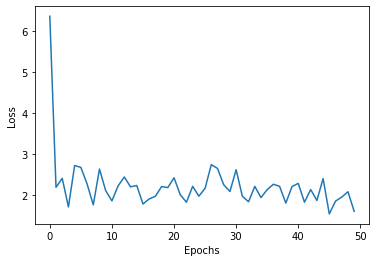

In [22]:
plt.plot(range(50),loss_vals)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

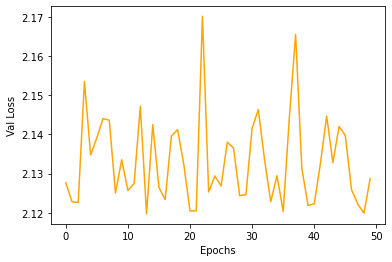

In [7]:
import matplotlib.pyplot as plt
#plt.plot(range(50),loss_vals)
plt.plot(range(50),val_loss_vals,color='orange')
plt.xlabel("Epochs")
plt.ylabel('Val Loss')
plt.show()